In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(suppress=True)
from tqdm import tqdm, trange

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
torch.set_printoptions(sci_mode=False)
from torchvision import datasets, transforms

In [2]:
# attempt to autodetect device
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")

using device: mps


In [3]:
# Define a transform to convert to tensor (we'll normalize later)
transform = transforms.ToTensor()

# Download and load the training data
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

BS = 128
loaders = {
    'train' : torch.utils.data.DataLoader(train_dataset, 
                                          batch_size=BS, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=BS, 
                                          shuffle=True, 
                                          num_workers=1),
}

In [4]:
class ConvModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        #self.pool1 =  nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2)
        #self.pool2 =  nn.MaxPool2d(2)
        self.l2 = nn.Linear(16*28*28,10)
        self.sm = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #x = self.pool1(x)
        x = F.relu(self.conv2(x))
        #x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.l2(x)
        x = self.sm(x)
        return x
model = ConvModel()
model.to(device)

ConvModel(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (l2): Linear(in_features=12544, out_features=10, bias=True)
  (sm): LogSoftmax(dim=1)
)

In [5]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0)
#optim = torch.optim.Adam(model.parameters(), lr = 0.01)


Loss: 0.1213 Accuracy: 0.94
Loss: 0.0856 Accuracy: 0.98


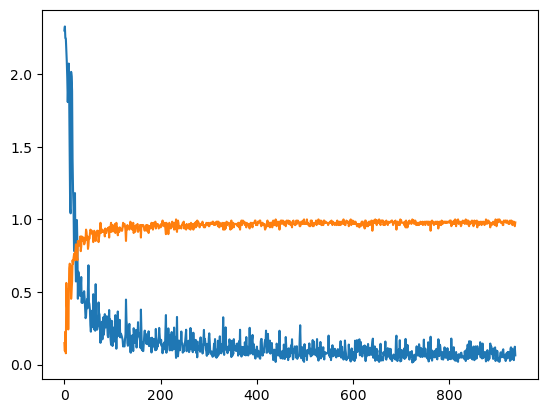

In [6]:
losses, accuracies = [], []
model.train()
num_epochs = 2
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(loaders['train']):
        optim.zero_grad()
        X = images.reshape((-1, 1, 28, 28)).float()
        X = X.to(device)
        Y = labels.long()
        Y = Y.to(device)
        preds = model(X)
        loss = criterion(preds, Y)
        loss = loss.mean()
        loss.backward()
        optim.step()
        cat = torch.argmax(preds, dim=1)
        #print("Cat: {} Y: {}".format(cat, Y))
        accuracy = (cat == Y).float().mean()
        loss, accuracy = loss.item(), accuracy.item()
        losses.append(loss)
        accuracies.append(accuracy)
    
        if (i+1) % 250 == 0:
            print('Loss: {:.4f} Accuracy: {:.2f}'.format(loss, accuracy))
    
#plt.ylim(-0.1, 1.1)
plt.plot(losses)
plt.plot(accuracies)

In [7]:
model.eval()
total_loss = 0
total_accuracy = 0
num_batches = 0

with torch.no_grad():
    for images, labels in loaders['test']:
        X = images.reshape((-1, 1, 28, 28)).float()
        X = X.to(device)
        Y = labels.long()
        Y = Y.to(device)
        preds = model(X)
        loss = criterion(preds, Y)
        loss = loss.mean()
        cat = torch.argmax(preds, dim=1)
        accuracy = (cat == Y).float().mean()
        
        total_loss += loss.item()
        total_accuracy += accuracy.item()
        num_batches += 1

average_loss = total_loss / num_batches
average_accuracy = total_accuracy / num_batches
print(f"Average loss: {average_loss:.4f}, Average accuracy: {average_accuracy:.4f}")


Average loss: 0.0643, Average accuracy: 0.9797
